In this notebook we test if GPU is working... we will run this notebook on both a server with GPU and on my local machine with only CPU. 

This notebook is identical to gpu_test and gpu_test_with_flags

On the server, we check nvidia-smi to see if it is actually using GPU. 

Then, we compare runtimes for this notebook on GPU vs CPU to make sure that GPU isn't inadvertently making things slower (e.g. by repeatedly moving data btwn CPU/GPU, etc). Also we should check how much faster GPU makes things. 

### imports and setup

In [1]:
# ipython extension to autoreload imported modules so that any changes will be up to date before running code in this nb
%load_ext autoreload 
%autoreload 2

In [2]:
from utils.jraph_training import train_and_evaluate_with_data, create_dataset
# from utils.jraph_models import MLPGraphNetwork
from utils.jraph_data import print_graph_fts
from utils.jraph_vis import plot_predictions
from utils.hyperparam_tuning import remove_bad_trials, get_best_trial_config, get_best_trial_workdir
import ml_collections
import optuna 
from flax import linen as nn
from functools import partial
from datetime import datetime
import os 

/Users/h.lu/Documents/_code/_research lorenz code/lorenzGNN/lorenzvenv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# set up logging
import logging
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

### set up functions for optuna

In [4]:
CHECKPOINT_PATH = "experiments/tuning"

In [5]:
def objective(trial, study_name, datasets):
    """ Defines the objective function to be optimized over, aka the validation loss of a model.
    
        Args:
            trial: object which characterizes the current run 
            datasets: dictionary of data. we explicitly pass this in so that we don't have to waste runtime regenerating the same dataset over and over. 
    """
    start = datetime.now()
    # create config 
    config = ml_collections.ConfigDict()

    # Optimizer.
    # config.optimizer = "adam"
    config.optimizer = trial.suggest_categorical("optimizer", ["adam", "sgd"])
    config.learning_rate = trial.suggest_float('learning_rate', 1e-4, 5e-2, 
                                               log=True)
    if config.optimizer == "sgd":
        config.momentum = trial.suggest_float('momentum', 0, 0.999) # upper bound is inclusive, and we want to exclude a momentum of 1 because that would yield no decay 

    # Data params that are used in training 
    config.output_steps = 4

    # Training hyperparameters.
    config.batch_size = 1 # variable currently not used
    config.epochs = 200
    config.log_every_epochs = 5
    config.eval_every_epochs = 5
    config.checkpoint_every_epochs = 10

    # GNN hyperparameters.
    config.model = 'MLPBlock'
    config.dropout_rate = trial.suggest_float('dropout_rate', 0, 0.6)
    config.skip_connections = False # This was throwing a broadcast error in add_graphs_tuples_nodes when this was set to True
    config.layer_norm = False # TODO perhaps we want to turn on later
    config.activation = trial.suggest_categorical(
        'activation', ["relu", "elu", "leaky_relu"])
    
    # choose the hidden layer feature size using powers of 2 
    config.edge_features = (
        2**trial.suggest_int("edge_mlp_1_power", 1, 3), # range 2 - 8; upper bound is inclusive
        2**trial.suggest_int("edge_mlp_2_power", 1, 3), # range 2 - 8
    )
    config.node_features = (
        2**trial.suggest_int("node_mlp_1_power", 1, 8), # range 2 - 512
        2**trial.suggest_int("node_mlp_2_power", 1, 8), # range 2 - 512
        2) 
    # note the last feature size will be the number of features that the graph predicts
    config.global_features = None

    # generate a workdir 
    # TODO: check if we actually care about referencing this in the future or if we can just create a temp dir 
    workdir=os.path.join(CHECKPOINT_PATH, study_name, f"trial_{trial.number}")

    # run training 
    state, train_metrics, eval_metrics_dict = train_and_evaluate_with_data(config=config, workdir=workdir, datasets=datasets, trial=trial)
    
    # retrieve and return val loss (MSE)
    # print("eval_metrics_dict['val'].loss", eval_metrics_dict['val'].loss)
    # print("eval_metrics_dict['val'].compute()['loss']", eval_metrics_dict['val'].compute()['loss'])
    # print()
    end = datetime.now()

    print(f"objective func took {end - start} to run")
    return eval_metrics_dict['val'].compute()['loss']




In [6]:
def get_data_config():
    config = ml_collections.ConfigDict()

    config.n_samples=10_000
    config.input_steps=1
    config.output_delay=8 # predict 24 hrs into the future 
    config.output_steps=4
    config.timestep_duration=3 # equivalent to 3 hours
    # note a 3 hour timestep resolution would be 5*24/3=40
    # if the time_resolution is 120, then a sampling frequency of 3 would achieve a 3 hour timestep 
    config.sample_buffer = -1 * (config.input_steps + config.output_delay + config.output_steps - 1) # negative buffer so that our sample input are continuous (i.e. the first sample would overlap a bit with consecutive samples) 
        # number of timesteps strictly between the end 
        # of one full sample and the start of the next sample
    config.time_resolution=120 # the number of 
                # raw data points generated per time unit, equivalent to the 
                # number of data points generated per 5 days in the simulation
    config.init_buffer_samples=100
    config.train_pct=0.7
    config.val_pct=0.2
    config.test_pct=0.1
    config.K=36
    config.F=8
    config.c=10
    config.b=10
    config.h=1
    config.seed=42
    config.normalize=True
    config.fully_connected_edges=False

    return config

In [7]:
def prepare_study(study_name):
    # generate dataset 
    data_start = datetime.now()
    dataset_config = get_data_config()
    datasets = create_dataset(dataset_config)
    data_end = datetime.now()
    print(f"dataset took {data_end - data_start} time to generate")
    
    print_graph_fts(datasets['train']['inputs'][0][0])

    # get the objective function that reuses the pre-generated datasets 
    objective_partial = partial(objective, study_name=study_name, 
                                datasets=datasets)

    # run optimization study
    db_path = os.path.join(CHECKPOINT_PATH, study_name, "optuna_hparam_search.db")
    if not os.path.exists(os.path.join(CHECKPOINT_PATH, study_name)):
        os.makedirs(os.path.join(CHECKPOINT_PATH, study_name))

    study = optuna.create_study(
        study_name=study_name,
        storage=f'sqlite:///{db_path}', # generates a new db if it doesn't exist
        direction='minimize',
        pruner=optuna.pruners.MedianPruner(
            n_startup_trials=5, 
            n_warmup_steps=50,
            ), 
        load_if_exists=True, 
    )
    
    return study, objective_partial

### hyperparameter tuning 

In [8]:
# get study
study_cpu, objective_partial = prepare_study(study_name="hparam_study_cpu")

dataset took 0:00:37.054621 time to generate
Number of nodes: 36
Number of edges: 180
Node features shape: (36, 2)
Edge features shape: (180, 1)
Global features shape: (1, 1)


[I 2023-12-08 13:04:48,503] A new study created in RDB with name: hparam_study_cpu


CPU times: user 34.6 s, sys: 1.26 s, total: 35.8 s
Wall time: 37.5 s


In [9]:
study_cpu.optimize(objective_partial, 
                n_trials=10-len(study_cpu.trials), 
                n_jobs=1)

[I 2023-12-08 13:04:56,708] Trial 0 pruned. 
[I 2023-12-08 13:22:38,822] Trial 1 finished with value: 0.67446368932724 and parameters: {'optimizer': 'adam', 'learning_rate': 0.009643204385584133, 'dropout_rate': 0.04844491534090436, 'activation': 'elu', 'edge_mlp_1_power': 3, 'edge_mlp_2_power': 2, 'node_mlp_1_power': 1, 'node_mlp_2_power': 1}. Best is trial 1 with value: 0.67446368932724.


objective func took 0:17:41.891822 to run


[I 2023-12-08 13:42:03,672] Trial 2 finished with value: 0.8382586240768433 and parameters: {'optimizer': 'sgd', 'learning_rate': 0.00014121566333823526, 'momentum': 0.33957371901203565, 'dropout_rate': 0.21918600756348391, 'activation': 'relu', 'edge_mlp_1_power': 2, 'edge_mlp_2_power': 2, 'node_mlp_1_power': 3, 'node_mlp_2_power': 1}. Best is trial 1 with value: 0.67446368932724.


objective func took 0:19:24.716646 to run


[I 2023-12-08 13:42:11,529] Trial 3 pruned. 
[I 2023-12-08 13:57:53,807] Trial 4 finished with value: 0.5845929384231567 and parameters: {'optimizer': 'adam', 'learning_rate': 0.00022623510477730988, 'dropout_rate': 0.1106627231557866, 'activation': 'elu', 'edge_mlp_1_power': 3, 'edge_mlp_2_power': 3, 'node_mlp_1_power': 3, 'node_mlp_2_power': 3}. Best is trial 4 with value: 0.5845929384231567.


objective func took 0:15:42.172313 to run


In [ ]:
datasets = create_dataset(get_data_config())

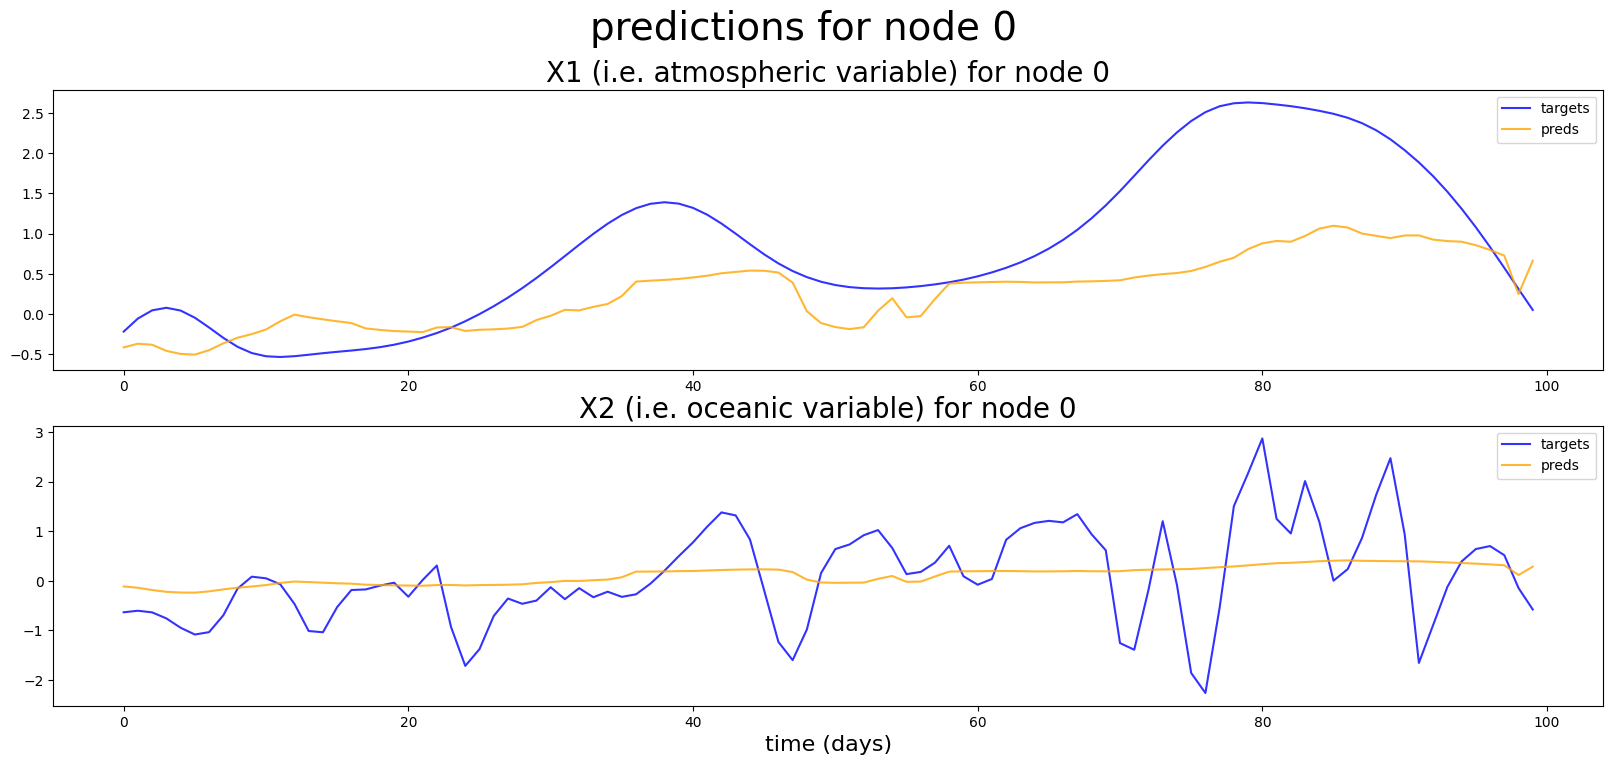

In [ ]:
plot_predictions(
    config=get_best_trial_config(study=study_cpu),
    workdir=get_best_trial_workdir(study=study_cpu), # for loading checkpoints 
    plot_ith_rollout_step=0, # 0 indexed # for this study, we have a 4-step rollout 
    # dataset,
    # preds,
    # timestep_duration,
    # n_rollout_steps,
    #  total_steps,
    node=0, # 0-indexed 
    plot_mode="val", # i.e. "train"/"val"/"test"
    datasets=datasets,
    plot_all=False, # if false, only plot the first 100 
)

In [ ]:
study_vis = remove_bad_trials(study_cpu)

[I 2023-12-02 16:24:35,287] A new study created in RDB with name: hparam_study_11_trimmed


In [ ]:
fig = optuna.visualization.plot_intermediate_values(study_vis)
fig.show()

In [ ]:
# plot the estimated accuracy surface over hyperparameters:
fig = optuna.visualization.plot_contour(study_vis, params=['learning_rate', 'dropout_rate'])
fig.show()

In [ ]:
# plot the estimated accuracy surface over hyperparameters:
fig = optuna.visualization.plot_contour(study_vis, params=['learning_rate', 'edge_mlp_1_power'])
fig.show()

In [ ]:
# plot the estimated accuracy surface over hyperparameters:
fig = optuna.visualization.plot_contour(study_vis, params=['learning_rate', 'node_mlp_1_power'])
fig.show()

In [ ]:
# plot the estimated accuracy surface over hyperparameters:
fig = optuna.visualization.plot_contour(study_vis, params=['learning_rate', 'optimizer'])

fig.show()

In [ ]:
# plot the estimated accuracy surface over hyperparameters:
fig = optuna.visualization.plot_contour(study_vis, params=['optimizer', 'activation'])
fig.show()

In [ ]:
# plot the estimated accuracy surface over hyperparameters:
fig = optuna.visualization.plot_contour(study_vis, params=['activation', 'node_mlp_1_power'])
fig.show()